In [55]:
from tensorflow.keras import models
from tensorflow.keras.layers import Activation, ZeroPadding2D, MaxPooling2D, Conv2D, Flatten, Dense, Dropout
from tensorflow.keras import regularizers, constraints
from tensorflow.keras import optimizers, losses
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [56]:
data = pd.read_csv('data/umist_cropped_with_cluster_id_training.csv')
val_data = pd.read_csv(r'data\validation_data\umist_cropped_with_cluster_id_val.csv')
test_data = pd.read_csv('data/test_data/umist_cropped_with_cluster_id_test.csv')

In [57]:
X_train = data.drop(['cluster_id'],axis = 1)
y_train = data['cluster_id']

X_val = val_data.drop(['cluster_id'],axis = 1)
y_val = val_data['cluster_id']

X_test = test_data.drop(['cluster_id'],axis = 1)
y_test = test_data['cluster_id']

In [58]:
# Extract pixel values and reshape
X_train = X_train.values.reshape(-1, 112, 92, 1)

X_val = X_val.values.reshape(-1, 112, 92, 1)

X_test = X_test.values.reshape(-1, 112, 92, 1)

In [59]:
# Normalize the images
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

In [60]:
# Convert to TensorFlow tensors
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)

X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
y_val = tf.convert_to_tensor(y_val, dtype=tf.float32)

X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

In [61]:
print(f"Image tensor shape: {X_train.shape}")  # Should print (num_samples, 112, 92, 1)

Image tensor shape: (600, 112, 92, 1)


In [62]:
IMAGE_WIDTH = 112
IMAGE_HEIGHT = 92
NUM_CLASSES = np.unique(y_train).shape[0]
BATCH_SIZE = 32
EPOCHS = 20
NUMBER_OF_TRAINING_IMAGES = 600

In [63]:
model = models.Sequential()

model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 1), padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2=0.01)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2=0.01)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu', kernel_initializer="glorot_uniform", kernel_regularizer=regularizers.l2(l2=0.01)))

model.add(Dropout(0.5))

model.add(Dense(NUM_CLASSES, activation='softmax', kernel_initializer="glorot_uniform"))

In [64]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 112, 92, 512)   │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 56, 46, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 54, 44, 128)    │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 27, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 25, 20, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 12, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 7680)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     3,932,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 24)             │        12,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,613,848 (17.60 MB)

 Trainable params: 4,613,848 (17.60 MB)

 Non-trainable params: 0 (0.00 B)

In [65]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    mode='auto',
)

model_checkpoint = ModelCheckpoint(
    filepath='models/classifier/best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1,
)


In [66]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.0003),
    metrics=["accuracy"]
)

In [67]:
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True, validation_data=(X_val, y_val), callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0534 - loss: 14.2132
Epoch 1: val_accuracy improved from -inf to 0.05310, saving model to models/classifier/best_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.0536 - loss: 14.1484 - val_accuracy: 0.0531 - val_loss: 10.2368
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1172 - loss: 9.3224
Epoch 2: val_accuracy improved from 0.05310 to 0.28319, saving model to models/classifier/best_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.1174 - loss: 9.2836 - val_accuracy: 0.2832 - val_loss: 6.7839
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2540 - loss: 6.1956
Epoch 3: val_accuracy improved from 0.28319 to 0.47788, saving model to models/classifier/best_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.2563 - loss: 6.1680 - val_accuracy: 0.4779 - val_loss: 4.3445
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4391 - loss: 4.1396
Ep

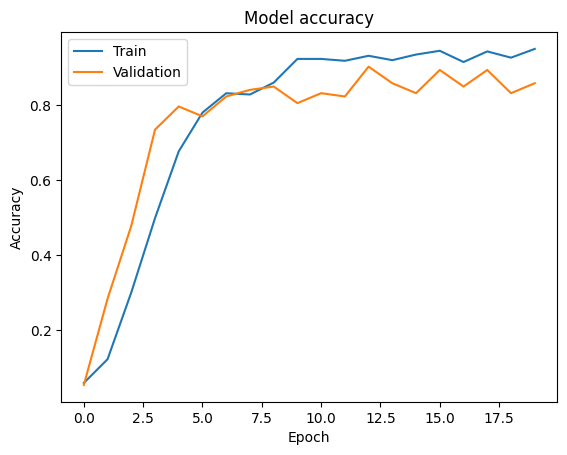

In [68]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

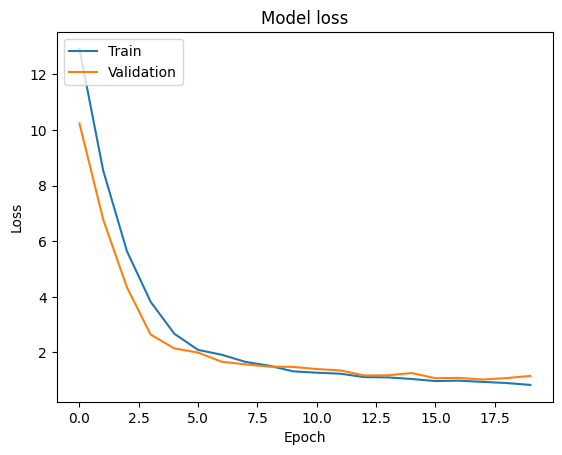

In [69]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [70]:
best_model = models.load_model('models/classifier/best_model.keras')

In [71]:
test_loss, test_accuracy = best_model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)

print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - accuracy: 0.8988 - loss: 1.2841
Test loss: 1.4031366109848022
Test accuracy: 0.8849557638168335


In [72]:
y_test_pred = best_model.predict(X_test)

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002A98D1B4A40> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step


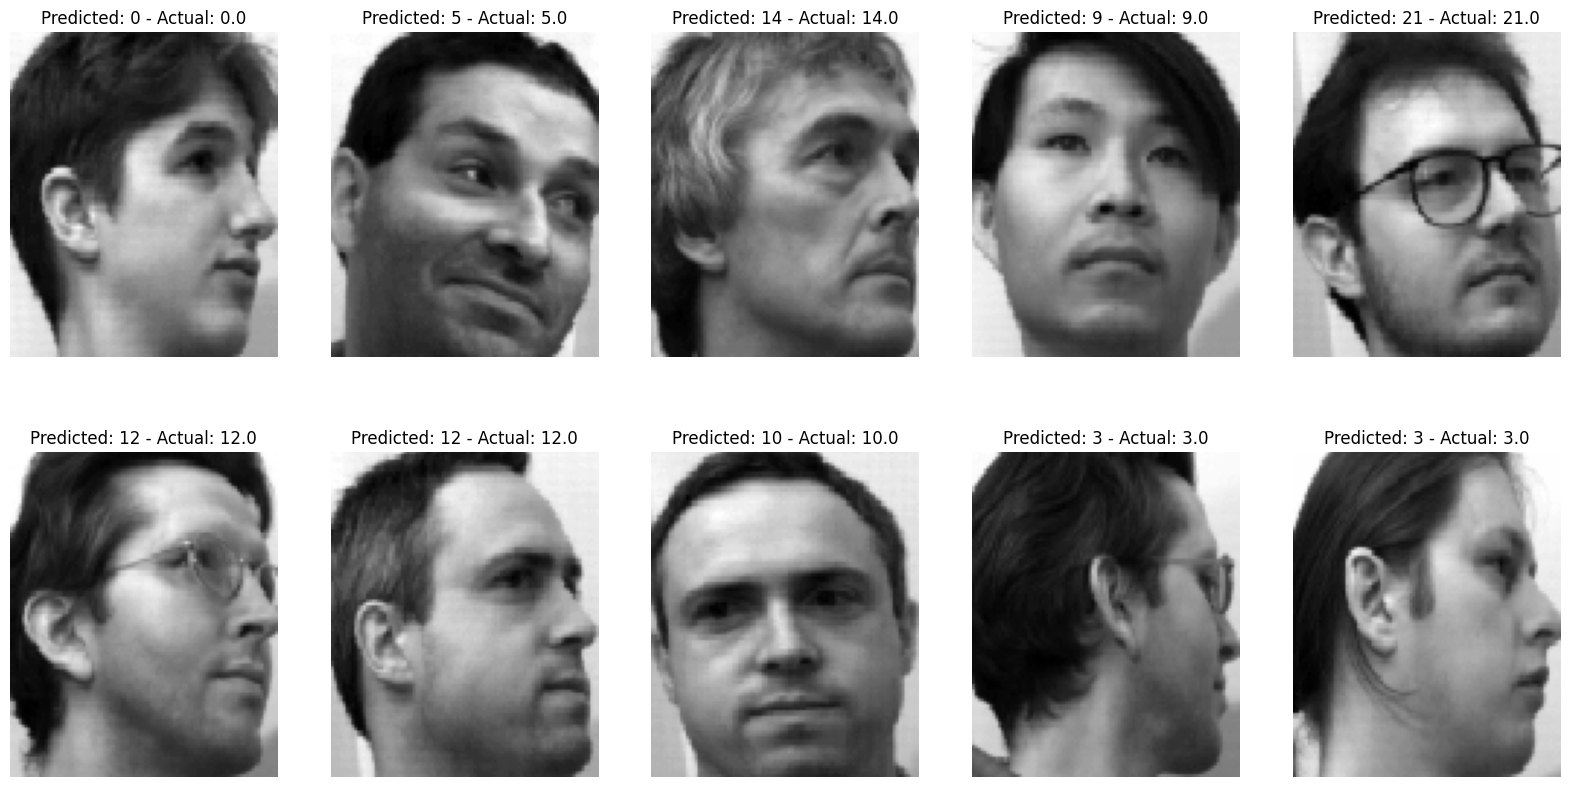

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(20, 10))

for i in range(10):
    ax[i // 5, i % 5].imshow(X_test[i].numpy().reshape(112, 92), cmap='gray')
    ax[i // 5, i % 5].set_title(f"Predicted: {np.argmax(y_test_pred[i])} - Actual: {y_test[i].numpy()}")
    ax[i // 5, i % 5].axis('off')

plt.show()